final project
===
due: June 30 2022

authors: pegler, prüwasser, scheftner

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
from glob import glob


files = glob("data/final_data/*.csv")

dfs = []

for file in files:

    dfs.append(pd.read_csv(file, sep=";", index_col=0))

## Data exploration

In [3]:
files[13]

'data/final_data/auc_ec_eo_with_gamma.csv'

In [4]:
df = dfs[13]
df.head()

,Factor,Power,Time,ROI,Frequency,Eyes
id,,,,,,
1,GAMMA_aucp_PRE_EC_midline,0.00390,Pre,Midline,Gamma,EC
2,GAMMA_aucp_PRE_EC_midline,0.00496,Pre,Midline,Gamma,EC
3,GAMMA_aucp_PRE_EC_midline,0.00612,Pre,Midline,Gamma,EC
4,GAMMA_aucp_PRE_EC_midline,0.01122,Pre,Midline,Gamma,EC
5,GAMMA_aucp_PRE_EC_midline,0.02378,Pre,Midline,Gamma,EC


In [5]:
df_grp = df.groupby(["Time", "ROI", "Frequency", "Eyes"]).mean().reset_index()
df_grp = df_grp.pivot(index=["ROI", "Frequency", "Eyes"], columns="Time", values="Power").reset_index()
df_grp = df_grp.reindex(columns=["ROI", "Frequency", "Eyes", "Pre", "Post"])
df_grp["Diff"] = df_grp["Post"] - df_grp["Pre"]
df_grp

Time,ROI,Frequency,Eyes,Pre,Post,Diff
0,Midline,Alpha,EC,0.257031,0.285041,0.028010
1,Midline,Alpha,EO,0.168580,0.183617,0.015037
2,Midline,Delta,EC,0.193173,0.187387,-0.005786
3,Midline,Delta,EO,0.228416,0.215366,-0.013050
4,Midline,Gamma,EC,0.013781,0.013026,-0.000756
5,Midline,Gamma,EO,0.016463,0.018830,0.002367
6,Midline,Theta,EC,0.197239,0.177586,-0.019653
7,Midline,Theta,EO,0.204900,0.197930,-0.006970
8,Parietotemporal,Alpha,EC,0.304755,0.326416,0.021661
9,Parietotemporal,Alpha,EO,0.201677,0.197118,-0.004559


## EEG power across all conditions

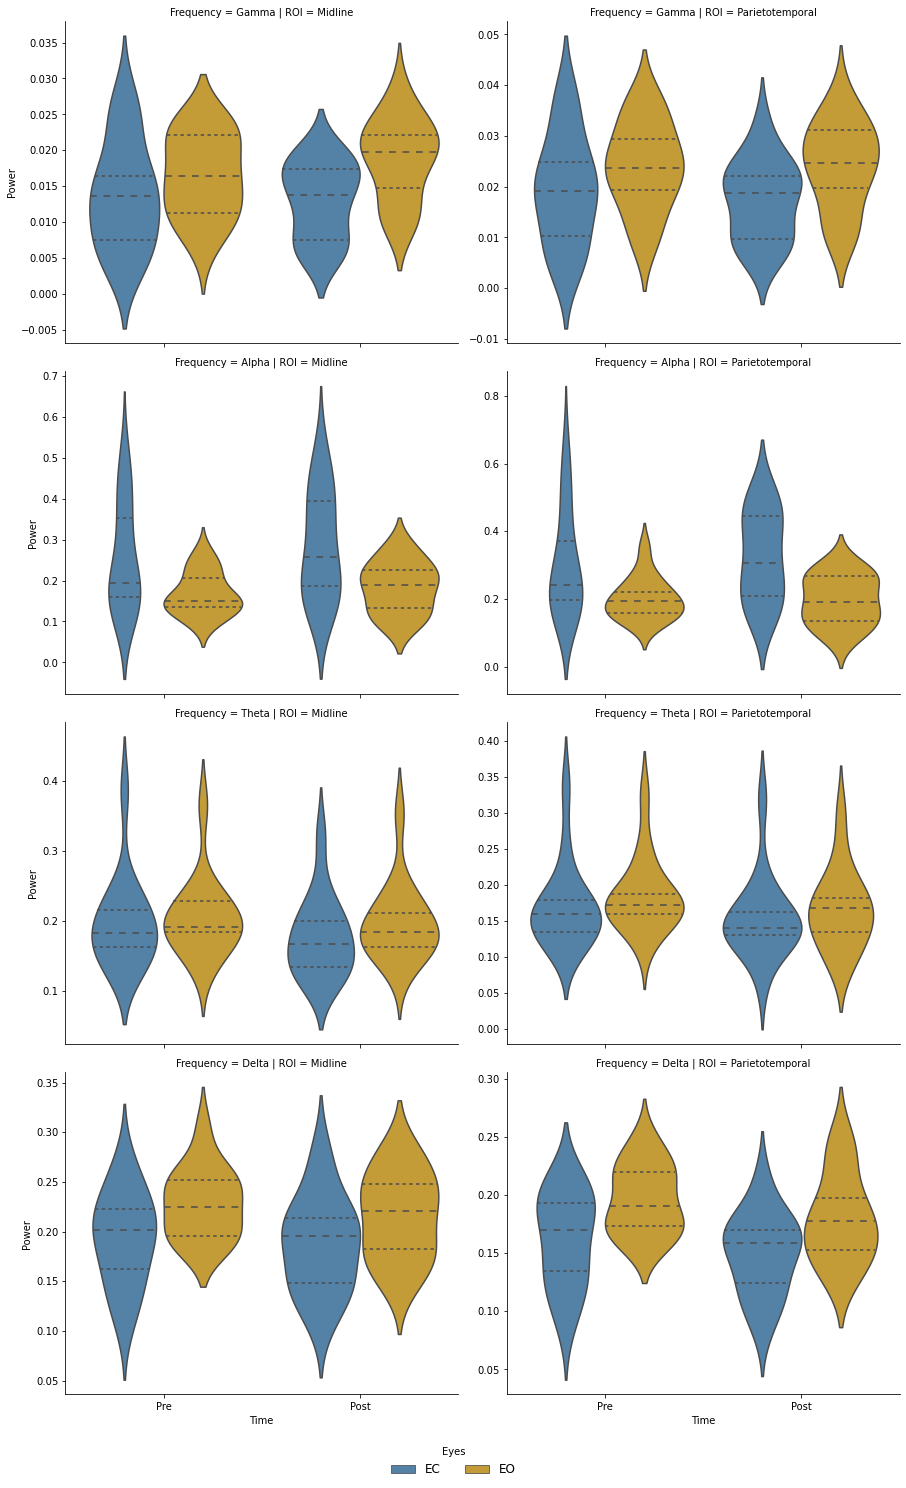

In [7]:
import seaborn as sns

g = sns.catplot(data=df,
                x="Time",
                y="Power",
                hue="Eyes",
                col="ROI",
                row="Frequency",
                palette=sns.color_palette(["steelblue", "goldenrod", "salmon", "firebrick"]),
                kind="violin", split=False, height=5, aspect=1.2, inner="quartile",
                sharey=False)
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0), fontsize=12, ncol=2)
plt.tight_layout()

## Testing for mean difference

### $t$-test

In [46]:
from pingouin import ttest

def get_ttest(df, conditions=None, paired=True, alternative='two-sided', correction='auto', r=0.707, conf=0.95):
    pre, post = df.loc[df["Time"]=="Pre"], df.loc[df["Time"]=="Post"]
    if conditions != None:
        if type(conditions) != dict:
            raise Exception("Condition argument needs to be a dict!")
        for c in conditions:
            pre = pre.loc[pre[c]==conditions[c]]
            post = post.loc[post[c]==conditions[c]]
    tt_res = ttest(pre["Power"], post["Power"], paired=paired, alternative=alternative, correction=correction, r=r, confidence=conf)
    return tt_res

#### Overall

In [47]:
get_ttest(df)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.374195,223,two-sided,0.170761,"[-0.0, 0.01]",0.029173,0.189,0.071919


#### Conditions

In [100]:
freq_s = ["Alpha", "Delta", "Gamma", "Theta"]
roi_s = ["Midline", "Parietotemporal"]
eyes_s = ["EO", "EC"]

tt_res = None
for freq in freq_s:
    for roi in roi_s:
        for eyes in eyes_s:
            tmp = get_ttest(df, conditions = {"Frequency":freq, "ROI":roi, "Eyes":eyes})
            tmp["Frequency"] = freq
            tmp["ROI"] = roi
            tmp["Eyes"] = eyes
            if type(tt_res) != pd.core.frame.DataFrame:
                tt_res = tmp
            else:
                tt_res = pd.concat([tt_res, tmp], sort=False).reset_index(drop=True)
tt_res = tt_res.set_index(["Frequency", "ROI", "Eyes"])
tt_res

T  dof alternative     p-val  \
Frequency ROI             Eyes                                        
Alpha     Midline         EO   -1.809307   13   two-sided  0.093576   
                          EC   -2.332492   13   two-sided  0.036394   
          Parietotemporal EO    0.365916   13   two-sided  0.720313   
                          EC   -1.103179   13   two-sided  0.289953   
Delta     Midline         EO    1.854440   13   two-sided  0.086495   
                          EC    1.021372   13   two-sided  0.325710   
          Parietotemporal EO    3.343845   13   two-sided  0.005283   
                          EC    2.249236   13   two-sided  0.042467   
Gamma     Midline         EO   -2.623542   13   two-sided  0.021044   
                          EC    0.887494   13   two-sided  0.390937   
          Parietotemporal EO   -0.050161   13   two-sided  0.960757   
                          EC    1.396356   13   two-sided  0.185994   
Theta     Midline         EO    0.735827   13   two-sided  0.474904   
                          EC    1.681222   13   two-sided  0.116572   
          Parietotemporal EO    2.544199   13   two-sided  0.024460   
                          EC    2.498032   13   two-sided  0.026688   

                                        CI95%   cohen-d   BF10     power  
Frequency ROI             Eyes                                            
Alpha     Midline         EO     [-0.03, 0.0]  0.264700  0.981  0.150878  
                          EC    [-0.05, -0.0]  0.213482  2.014  0.114915  
          Parietotemporal EO    [-0.02, 0.03]  0.068266  0.286  0.056467  
                          EC    [-0.06, 0.02]  0.150212  0.451  0.081713  
Delta     Midline         EO     [-0.0, 0.03]  0.330338   1.04  0.208802  
                          EC    [-0.01, 0.02]  0.121707  0.421  0.070710  
          Parietotemporal EO     [0.01, 0.03]  0.492474  9.613  0.400174  
                          EC      [0.0, 0.02]  0.329338  1.786  0.207823  
Gamma     Midline         EO     [-0.0, -0.0]  0.416427  3.107  0.303249  
                          EC      [-0.0, 0.0]  0.117639  0.378  0.069335  
          Parietotemporal EO      [-0.0, 0.0]  0.008794   0.27  0.050107  
                          EC     [-0.0, 0.01]  0.219019  0.603  0.118409  
Theta     Midline         EO    [-0.01, 0.03]  0.125879  0.341  0.072170  
                          EC    [-0.01, 0.04]  0.320145  0.836  0.198958  
          Parietotemporal EO      [0.0, 0.04]  0.361114  2.756  0.240328  
                          EC      [0.0, 0.03]  0.286544  2.571  0.168700

### Permutation test

In [131]:
#

### Bayesian estimation

In [20]:
from pingouin import bayesfactor_ttest

#### Overall

In [32]:
bayesfactor_ttest(t=tt_rest["T"]["T-test"], nx=len(df)/2, paired=True, alternative='two-sided', r=0.707)

0.18913573589168417

Some example with random data inspired by 
* https://psycnet.apa.org/record/2012-18082-001
* https://www.sumsar.net/best_online/

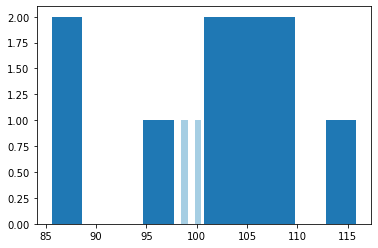

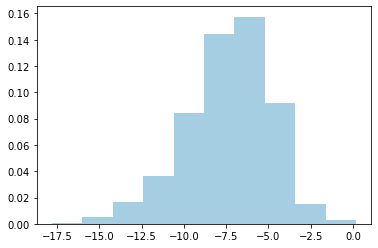

In [138]:
import numpy as np
import matplotlib.pyplot as plt

def dnorm(x, mu, sig):
    return 1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sig**2))

def dexp(x, l):
    return l * np.exp(- l*x)

def like(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(sample1, mu1, sig1).prod()*dnorm(sample2, mu2, sig2).prod()

def prior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(mu1, pooled.mean(), 1000*pooled.std()) * dnorm(mu2, pooled.mean(), 1000*pooled.std()) * dexp(sig1, 0.1) * dexp(sig2, 0.1)

def posterior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return like([mu1, sig1, mu2, sig2])*prior([mu1, sig1, mu2, sig2])


#create samples
sample1 = np.random.normal(100, 3, 8)
sample2 = np.random.normal(100, 7, 10)

pooled= np.append(sample1, sample2)

plt.figure(0)
plt.hist(sample1)
plt.hist(sample2)
plt.show(block=False)

mu1 = 100 
sig1 = 10
mu2 = 100
sig2 = 10
parameters = np.array([mu1, sig1, mu2, sig2])

niter = 10000

results = np.zeros([niter, 4])
results[1,:] = parameters

for iteration in np.arange(2,niter):
    candidate = parameters + np.random.normal(0,0.5,4)
    ratio = posterior(candidate)/posterior(parameters)
    if np.random.uniform() < ratio:
        parameters = candidate
    results[iteration,:] = parameters

#burn-in
results = results[499:niter-1,:]

mu1 = results[:,1]
mu2 = results[:,3]

d = (mu1 - mu2)
p_value = np.mean(d > 0)

plt.figure(1)
plt.hist(d, density=True)
plt.show()